In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

ox.config(log_console=True, use_cache=True)
ox.__version__

'0.16.2'

In [2]:
votes = pd.read_csv("vote_coords.csv")
votes = votes.reset_index(drop=False)

In [3]:
votes.head()

,index,bssrs_match_code,party,vote,lon,lat,state,geoid,name
0,0,1000002,Independent,D,-87.983680,43.024712,WI,55079.0,Milwaukee
1,1,1000019,Independent,D,-91.191097,43.858408,WI,55063.0,La Crosse
2,2,1000051,Democrat,D,-89.638405,43.117813,WI,55025.0,Dane
3,3,1000158,Republican,R,-77.240304,40.576404,PA,42067.0,Juniata
4,4,1000214,Democrat,D,-80.216927,26.238386,FL,12011.0,Broward


In [29]:
%%time

edges = list()
nodes = list()

graphs = list()


for i in ["PA", "MI", "WI", "FL"]:
    
    state = votes[votes.state==i]
    
    for j in ["R", "D"]:
        
        print(f"{i} {j}...")
        
        party = state[state.vote==j]
        party = party.sample(frac=1)
        party = party.reset_index(drop=True)
        
        for k in np.arange(0, 32):
        
            chunk = party.iloc[k]
            
            try:
                G = ox.graph_from_point((chunk['lat'], chunk['lon']), 
                                        dist=1000, 
                                        network_type='drive')
                
                N, E = ox.graph_to_gdfs(G)
    
                N['bssrs_match_code'] = votes[votes['index']==chunk['index']].bssrs_match_code.iloc[0]
                E['bssrs_match_code'] = votes[votes['index']==chunk['index']].bssrs_match_code.iloc[0]
    
                nodes.append(N)
                edges.append(E)
    
                graphs.append(G)
        
            except:
                pass

PA R...
PA D...
MI R...
MI D...
WI R...
WI D...
FL R...
FL D...
CPU times: user 2min 11s, sys: 3.33 s, total: 2min 14s
Wall time: 14min 49s


In [36]:
edges = gpd.GeoDataFrame(pd.concat(edges, ignore_index=False))
nodes = gpd.GeoDataFrame(pd.concat(nodes, ignore_index=False))

In [37]:
edges_context = edges.merge(votes, left_on="bssrs_match_code", right_on="bssrs_match_code", how='left')
nodes_context = nodes.merge(votes, left_on="bssrs_match_code", right_on="bssrs_match_code", how='left')

In [46]:
street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}

In [86]:
current_state = edges_context[edges_context.state=="MI"]

In [87]:
current_codes = current_state.bssrs_match_code.unique()

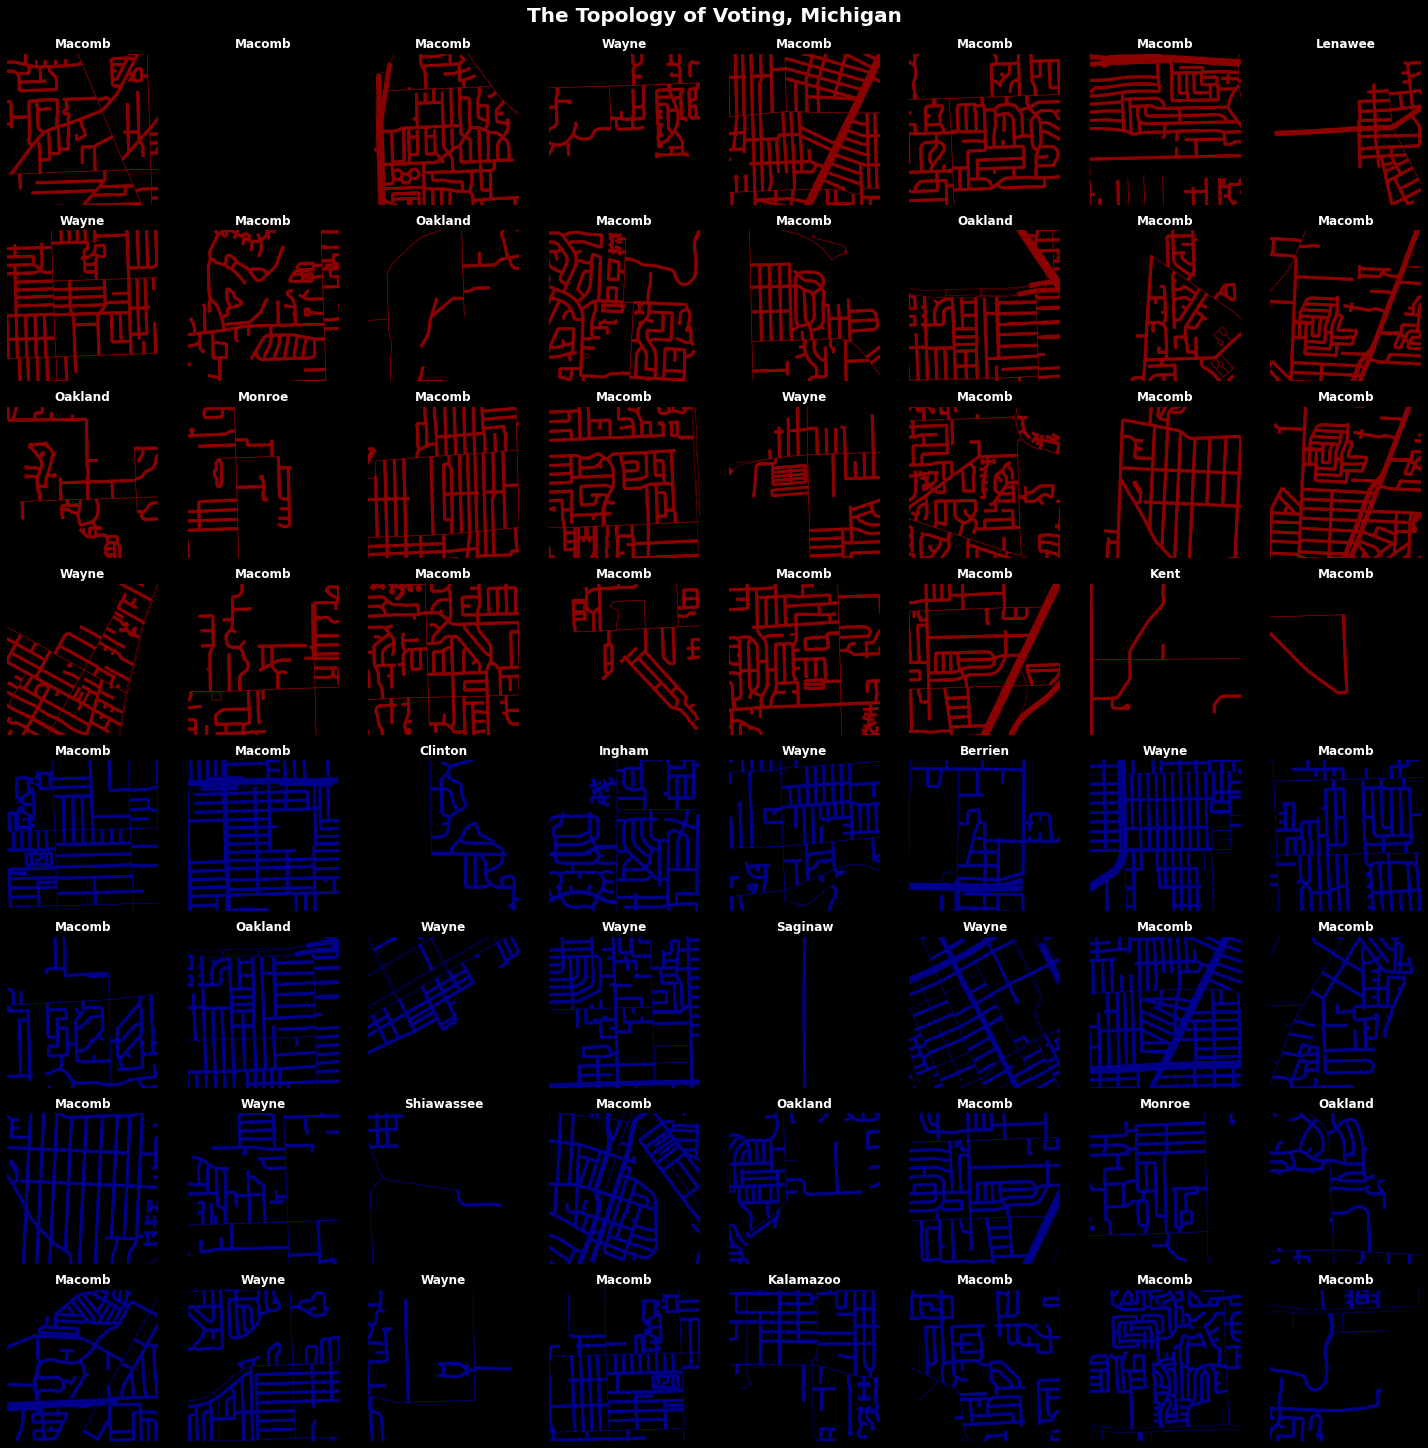

In [88]:
fig, axs = plt.subplots(8, 8, figsize=(20, 20), 
                        facecolor='k',
                        constrained_layout=True, 
                        subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 64):
    
    code = current_codes[i]
    hold = current_state[current_state['bssrs_match_code']==code]
    vote = votes[votes.bssrs_match_code==code].vote.iloc[0]
    name = votes[votes.bssrs_match_code==code].name.iloc[0]
    
    edge_linewidths = []
    
    default_width = 0.5
    
    for label in hold.highway:
        street_type = label[0] if isinstance(label, list) else label
    
        if street_type in street_widths:
            edge_linewidths.append(street_widths[street_type])
            
        else:
            edge_linewidths.append(default_width)
    
    if vote == "R":
        col = 'darkred'
        
    else:
        col = 'darkblue'
    
    hold.plot(ax=axs[i], color=col, lw=edge_linewidths)
    
    lat = votes[votes.bssrs_match_code==code].lat.iloc[0]
    lon = votes[votes.bssrs_match_code==code].lon.iloc[0]
    
    bbox = ox.utils_geo.bbox_from_point((lat, lon), 800, project_utm=False)
    
    north, south, east, west = bbox
    axs[i].set_ylim((south, north))
    axs[i].set_xlim((west, east))
    axs[i].set_title(name, 
                     color='w', weight='bold')

    axs[i].margins(0)
    axs[i].axis('off')
    
fig.suptitle('The Topology of Voting, Michigan', color='w', size=20, weight='bold')
fig.savefig('urban-topology_michigan.png', facecolor=fig.get_facecolor(), dpi=120, bbox_inches='tight')